In [1]:
import os
import datetime
import sagemaker
import pandas as pd
import numpy as np
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox
import matplotlib
import deepar_util as util
from deepar_util import DeepARPredictor

In [2]:
#Define parameters
interval = 'D' #Use D or H

assert interval == 'D' or interval == 'H'

if interval == 'D':
    prediction_length = 91 #when interval = D    
    context_length = 91
elif interval == 'H':
    prediction_length = 2184 #when interval = H
    context_length = 2184
    
    
mnemonics = ['CON','DAI','PAH3','BMW','VOW3']
target_column = 'EndPrice'
covariate_columns = ['StartPrice', 'MinPrice', 'MaxPrice']

train_test_split = 0.8
num_test_windows = 4
    


In [3]:
# Define IAM role and session
role = sagemaker.get_execution_role()
session = sagemaker.Session()

#Obtain container image URI for SageMaker-DeepAR algorithm, based on region
region = session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")
print("Model will be trained using container image : {}".format(image_name))

#Define training data location
s3_data_key = 'dbg-stockdata/source'
s3_bucket = session.default_bucket()
s3_output_path = "s3://{}/{}/{}/output".format(s3_bucket, s3_data_key, interval)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-741855114961


Model will be trained using container image : 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest


In [4]:
%%time
metrics=[]
metrics.extend(covariate_columns)
metrics.append(target_column)
stock_data_series, symbols = util.load_resampled_from_s3(interval, s3_bucket, s3_data_key, mnemonics, metrics)
print(stock_data_series.shape)

(484, 20)
CPU times: user 140 ms, sys: 20 ms, total: 160 ms
Wall time: 255 ms


In [5]:
%%time
train_data, test_data, train_start_dt, train_end_dt = util.generate_train_test_set(stock_data_series, target_column, covariate_columns, interval, train_test_split, num_test_windows)
end_training = pd.Timestamp(datetime.datetime.strptime(str(train_end_dt), "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %H:%M:%S"), freq = interval)

train_channel = util.write_dicts_to_file(train_data, interval, s3_bucket, s3_data_key, "train")
test_channel = util.write_dicts_to_file(test_data, interval, s3_bucket, s3_data_key, "test")
print("Train channel {}".format(train_channel))
print("Test channel {}".format(test_channel))

Sample Size = 484, Training Set: 387, Test Set: 4 * 24
Training Set: Starts at - 2017-07-03 00:00:00, Ends at - 2018-07-24 00:00:00
Time series for BMW added
Dynamic Feature - MaxPrice for BMW added
Dynamic Feature - MinPrice for BMW added
Dynamic Feature - StartPrice for BMW added
Time series for CON added
Dynamic Feature - MaxPrice for CON added
Dynamic Feature - MinPrice for CON added
Dynamic Feature - StartPrice for CON added
Time series for DAI added
Dynamic Feature - MaxPrice for DAI added
Dynamic Feature - MinPrice for DAI added
Dynamic Feature - StartPrice for DAI added
Time series for PAH3 added
Dynamic Feature - MaxPrice for PAH3 added
Dynamic Feature - MinPrice for PAH3 added
Dynamic Feature - StartPrice for PAH3 added
Time series for VOW3 added
Dynamic Feature - MaxPrice for VOW3 added
Dynamic Feature - MinPrice for VOW3 added
Dynamic Feature - StartPrice for VOW3 added
Time series for BMW added
Dynamic Feature - MaxPrice for BMW added
Dynamic Feature - MinPrice for BMW add

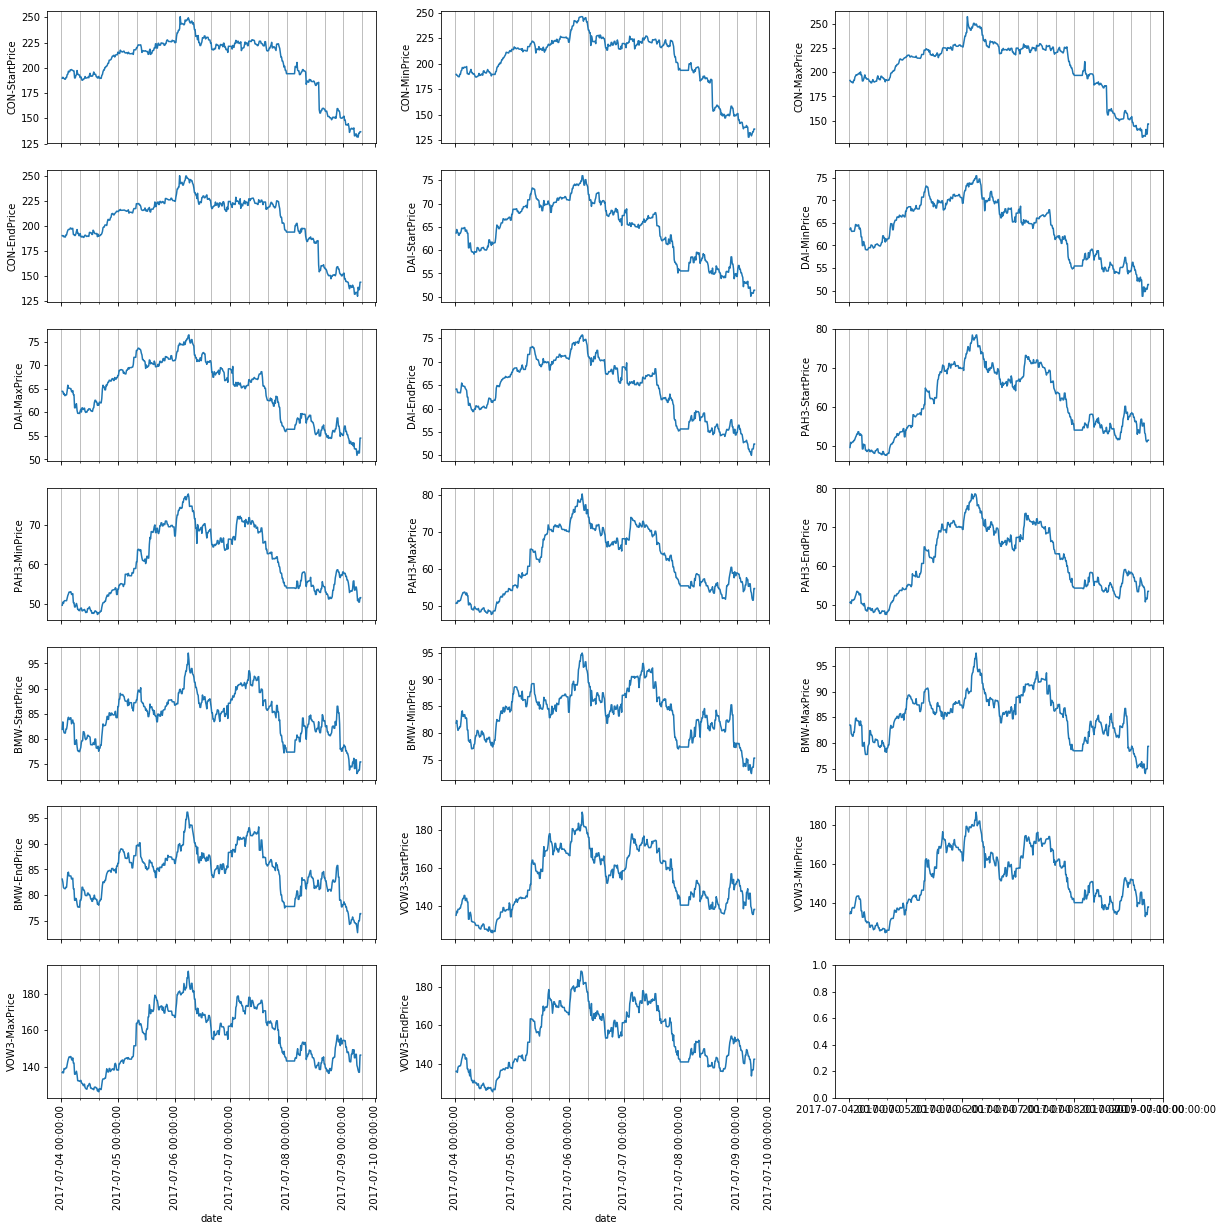

In [6]:
util.metrics_plot(mnemonics, metrics, stock_data_series)

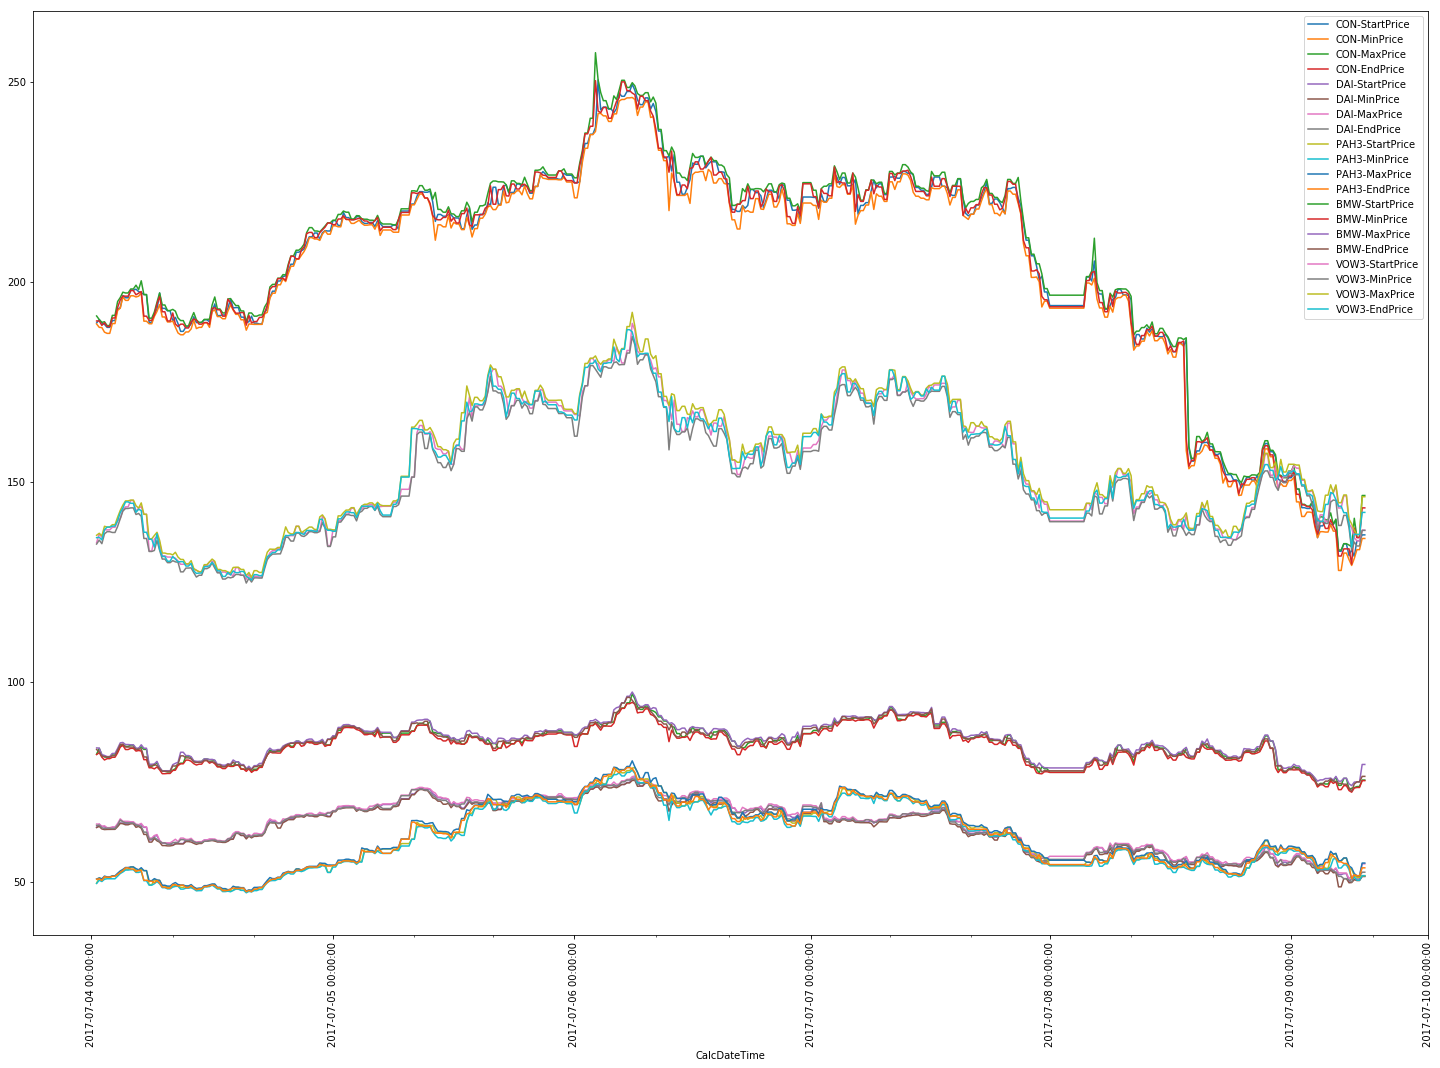

In [7]:
matplotlib.rcParams['figure.figsize'] = (25, 17) # use bigger graphs
util.timeseries_plot(mnemonics, metrics, stock_data_series)

In [ ]:
%%time

# Instantiate estimator with container image for DeepAR and backend EC2 instance(s)
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.18xlarge',
    base_job_name='dbg-deepar-{}'.format(interval),
    output_path=s3_output_path
)
hyperparameters = {
    "prediction_length": str(prediction_length), #number of time-steps model is trained to predict, always generates forecasts with this length
    "context_length": str(context_length), #number of time-points that the model gets to see before making the prediction, should be about same as the prediction_length
    "time_freq": interval, #granularity of the time series in the dataset
    "epochs": "200", #maximum number of passes over the training data
    "early_stopping_patience": "40", #training stops when no progress is made within the specified number of epochs
    "num_layers": "2", #number of hidden layers in the RNN, typically range from 1 to 4    
    "num_cells": "40", #number of cells to use in each hidden layer of the RNN, typically range from 30 to 100
    "mini_batch_size": "128", #size of mini-batches used during training, typically values range from 32 to 512
    "learning_rate": "1e-3", #learning rate used in training. Typical values range from 1e-4 to 1e-1
    "dropout_rate": "0.1", # dropout rate to use for regularization, typically less than 0.2. 
    "likelihood": "gaussian" #noise model used for uncertainty estimates - gaussian/beta/negative-binomial/student-T/deterministic-L1
}
estimator.set_hyperparameters(**hyperparameters)

# Train the model
data_channels = {
    "train": train_channel,
    "test": test_channel
}

estimator.fit(inputs=data_channels, wait=True)
estimator_job = estimator.latest_training_job.job_name
print("Estimator created at completion of training job {}".format(estimator_job))

In [ ]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)
print("Pedictor attached to Endpoint: {}".format(predictor.endpoint))

In [8]:
#estimator_job = 'dbg-deepar-D-2018-11-06-06-40-45-307'
predictor = DeepARPredictor(estimator_job)

In [9]:
ts, dynamic_feat, dummy = util.query_for_stock('BMW', target_column, covariate_columns, stock_data_series, prediction_length)
prediction = predictor.predict(ts=ts, dynamic_feat = dynamic_feat, quantiles=[0.10, 0.5, 0.90], return_samples=False)
prediction

Time series - EndPrice for BMW selected
Dynamic Feature - MaxPrice for BMW selected
Dynamic Feature - MinPrice for BMW selected
Dynamic Feature - StartPrice for BMW selected


,0.1,0.5,0.9
2018-07-30,80.153793,81.426231,82.541237
2018-07-31,80.369087,81.161240,82.276207
2018-08-01,78.833405,79.863297,81.193695
2018-08-02,79.345200,80.240585,81.368530
2018-08-03,79.075790,79.937927,80.770607
2018-08-04,78.434425,79.741089,81.238174
2018-08-05,79.351799,80.618141,81.683723
2018-08-06,79.516182,80.622902,81.866295
2018-08-07,78.817062,79.829971,80.781273
2018-08-08,78.775322,80.012329,81.244705


In [10]:
style = {'description_width': 'initial'}
@interact_manual(
    stock_id=IntSlider(min=0, max=len(mnemonics)-1, value=0, style=style),     
    forecast_horizon=IntSlider(min=0, max=int(context_length*0.75), steps = int(np.log10(context_length))+1, value=int(np.log10(context_length))+1, style=style),
    confidence=IntSlider(min=55, max=95, value=80, step=5, style=style),
    history_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(stock_id, forecast_horizon, confidence, history_plot, show_samples):
    util.plot(
        predictor,
        stock_id,
        mnemonics,
        stock_data_series,
        target_column,
        covariate_columns,
        prediction_length,        
        history_plot*prediction_length,
        forecast_date=end_training 
                        + datetime.timedelta(days=forecast_horizon) if interval == "D"
                            else datetime.timedelta(hours=forecast_horizon) if interval == "H"
                            else datetime.timedelta(weeks=forecast_horizon) if interval == "W"
                            else datetime.timedelta(days=forecast_horizon*30) if interval == "M"
                            else 0,
        show_samples=show_samples,        
        confidence=confidence
    )

interactive(children=(IntSlider(value=0, description='stock_id', max=4, style=SliderStyle(description_width='i…

## Delete EndPoint

Keep in mind that a running EndPoint has the chosen compute instances running, regardless of whether or not requests are being sent.

Therefore, in order to contain cost overrun, you should always delete the unused EndPoints. This doesn't delete the trained model artefacts, and at any point, the EndPoint can be reprovisioned, simply by using the correspodning training job name.


In [ ]:
predictor.delete_endpoint()